In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 500)

In [2]:
# csv_file = '311_Service_Requests_from_2010_to_Present.csv'

In [3]:
# iter_csv = pd.read_csv(csv_file, iterator=True, chunksize=1000, parse_dates=['Created Date'])
# df = pd.concat([chunk[chunk['Created Date'].dt.year == 2017] for chunk in iter_csv])
# df.to_csv('2017_data.csv')

In [4]:
# df.shape

In [5]:
df = pd.read_csv('2017_data.csv')

/Users/sean/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (9,18,32,33,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# 2.5 million lines
df.shape[0]

2445422

In [9]:
# remove whitespaces and capitalization from column names
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [12]:
# only 3000 boroughs don't have coordinates
print(df[df['borough'] == 'Unspecified'].shape[0])
print(df[(df['borough'] == 'Unspecified') & (df['latitude'].isnull())].shape[0])

41484
38575


In [14]:
df.drop(['unnamed:_0', 'unique_key', 'created_date', 'closed_date', 'open_data_channel_type', 'resolution_description', 'latitude', 'longitude',
         'landmark','vehicle_type', 'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name', 'bridge_highway_direction', 'road_ramp', 
         'bridge_highway_segment', 'agency', 'agency_name', 'location_type', 'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
         'intersection_street_1', 'intersection_street_2', 'address_type', 'city', 'facility_type', 'status', 'due_date', 'resolution_action_updated_date',
         'community_board', 'bbl', 'descriptor', 'x_coordinate_(state_plane)', 'y_coordinate_(state_plane)',
         'park_facility_name', 'park_borough'], axis=1, inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2445422 entries, 0 to 2445421
Data columns (total 4 columns):
complaint_type    object
incident_zip      object
borough           object
location          object
dtypes: object(4)
memory usage: 74.6+ MB


In [16]:
df['borough'] = df['borough'].str.lower()                # make borough lowercase
df['location'] = df['location'].str.strip('()')          # remove paranthesis from location
df['location'] = df['location'].str.replace(' ', '')     # remove whitespace from location
df['complaint_type'] = df['complaint_type'].str.lower()  # make complaint_type lowercase
df.rename(columns={'incident_zip': 'zip'}, inplace=True) # rename incident_zip to zip
df['zip'] = pd.to_numeric(df['zip'], errors='coerce')    # turns zip codes into floats and convert non-integer non-floats to NaN
df['zip'].fillna(0, inplace=True)                        # convert NaN to zero -- integer column cannot contain NaN
df['zip'] = df['zip'].astype(int)                        # convert datatype of zip to integer -- eliminates .0 from zip codes

In [19]:
# 41,500 unspecified lines for borough
df['borough'].value_counts()

brooklyn         760965
queens           586910
manhattan        480298
bronx            449048
staten island    126717
unspecified       41484
Name: borough, dtype: int64

In [20]:
# zip codes have multiple boroughs
df[df['zip'] == 11208]['borough'].value_counts()

brooklyn       28289
queens            91
unspecified       14
Name: borough, dtype: int64

In [21]:
# group zip and borough by zip, and aggregate the count of borough for each zip code
gby = df[['zip', 'borough']].groupby('zip').agg({'borough': pd.Series.nunique})

# 184 zip codes have at least 2 boroughs
zips_multiple_boroughs = gby[gby['borough'] != 1].index
print('zip codes with multiple boroughs:             {}'.format(len(zips_multiple_boroughs)))
print('number of lines that include these zip codes: {}'.format(df[df['zip'].isin(zips_multiple_boroughs)].shape[0]))

zip codes with multiple boroughs:             184
number of lines that include these zip codes: 2415046


In [22]:
# take the count of occurances for each borough for each zip code, and mask the borough
# with the greatest number of occurances to all lines for the current iteration's zip code
for z in zips_multiple_boroughs:
    unspecified_zips = []
    d = pd.Series.to_dict(df[df['zip'] == z]['borough'].value_counts())
    max_count = 0
    for k in d.keys():
        if d[k] > max_count:
            max_count = d[k]
            true_borough = k
    if true_borough == 'unspecified':
        print('unspecified has the most entries for zip {}'.format(z))
        unspecified_zips.append(z)
    else:
        df.loc[(df['zip'] == z), 'borough'] = true_borough

unspecified has the most entries for zip 0
unspecified has the most entries for zip 10580
unspecified has the most entries for zip 10710
unspecified has the most entries for zip 11030
unspecified has the most entries for zip 11096
unspecified has the most entries for zip 11559
unspecified has the most entries for zip 11563
unspecified has the most entries for zip 11581


In [23]:
# now only 7 zip codes contain 38 incidents with at least 2 boroughs
gby = df[['zip', 'borough']].groupby('zip').agg({'borough': pd.Series.nunique})
zips_multiple_boroughs = gby[gby['borough'] != 1].index
# remove zip 0 (NaN value) from zips_multiple_boroughs
zips_multiple_boroughs = zips_multiple_boroughs[1:]
print('zip codes with multiple boroughs:             {}'.format(len(zips_multiple_boroughs)))
print('number of lines that include these zip codes: {}'.format(df[df['zip'].isin(zips_multiple_boroughs)].shape[0]))

zip codes with multiple boroughs:             7
number of lines that include these zip codes: 38


In [28]:
# further zip code manipulations:
# 102,000 zip codes are NaN
# 65,000 entries have boroughs and don't have zip codes
print('Null Zip Codes:                {}'.format(df[df['zip'] == 0].shape[0]))
print('Null Zip Codes (with borough): {}\n'.format(df[(df['zip'] == 0) & (df['borough'] != 'unspecified')].shape[0]))
print('Distribution of null codes with borough:')
print(df[(df['zip'] == 0) & (df['borough'] != 'unspecified')]['borough'].value_counts())

Null Zip Codes:                102231
Null Zip Codes (with borough): 65121

Distribution of null codes with borough:
manhattan        17958
bronx            16052
queens           15260
brooklyn         14642
staten island     1209
Name: borough, dtype: int64


In [29]:
# aggregate borough and zip to get a count of the most frequently occuring zip code for each borough
df_z = df[['borough', 'zip', 'location']].groupby(['borough', 'zip']) \
                                         .count() \
                                         .reset_index() \
                                         .sort_values(['borough', 'location'], ascending=False) \
                                         .set_index(['borough', 'zip'])

In [30]:
# set the most populous zip code for each borough to a variable
brx = df_z.xs('bronx').head(1).index[0]
bk  = df_z.xs('brooklyn').head(1).index[0]
mhn = df_z.xs('manhattan').head(1).index[0]
qns = df_z.xs('queens').head(1).index[0]
sid = df_z.xs('staten island').head(1).index[0]

# mask these variables to null zip values where the borough is known
df.loc[(df['zip'] == 0) & (df['borough'] == 'bronx'), 'zip'] = brx
df.loc[(df['zip'] == 0) & (df['borough'] == 'brooklyn'), 'zip'] = bk
df.loc[(df['zip'] == 0) & (df['borough'] == 'manhattan'), 'zip'] = mhn
df.loc[(df['zip'] == 0) & (df['borough'] == 'queens'), 'zip'] = qns
df.loc[(df['zip'] == 0) & (df['borough'] == 'staten island'), 'zip'] = sid

del df_z

In [31]:
# now only 37110 zip codes are null, these do not have a borough
print('Null Zip Codes:                   {}'.format(df[df['zip'] == 0].shape[0]))
print('Null Zip Codes (with borough):    {}'.format(df[(df['zip'] == 0) & (df['borough'] != 'unspecified')].shape[0]))
print('Null Zip Codes (without borough): {}'.format(df[(df['zip'] == 0) & (df['borough'] == 'unspecified')].shape[0]))

Null Zip Codes:                   37110
Null Zip Codes (with borough):    0
Null Zip Codes (without borough): 37110


In [37]:
df['borough'].value_counts()

brooklyn         761450
queens           587119
manhattan        478700
bronx            451007
staten island    129068
Name: borough, dtype: int64

In [32]:
# dropping unspecified borough data
df = df[df['borough'] != 'unspecified'].copy()

In [33]:
# load in the 2010 population census dataset
# use this to generate a value for population for each borough
population = pd.read_csv('2010_Census_Population_By_Zipcode.csv', names=['zip', 'population'], skiprows=1)

In [34]:
population.head()

,zip,population
0,1001,16769
1,1002,29049
2,1003,10372
3,1005,5079
4,1007,14649


In [35]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33092 entries, 0 to 33091
Data columns (total 2 columns):
zip           33092 non-null int64
population    33092 non-null int64
dtypes: int64(2)
memory usage: 517.1 KB


In [36]:
# adding population column to main DataFrame
df = df.merge(population, how='left', on='zip')

### Ten Most Common Overall Complaint Types
---

In [61]:
# grouping by complaint type to get the ten most common overall complaint types
df_c = df[['complaint_type', 'location']].groupby(by=['complaint_type']) \
                                         .count() \
                                         .sort_values(by=['location'], ascending=False)
df_c.rename(columns={'location':'count'}, inplace=True)

In [62]:
common_complaints = df_c.head(10).index
df_c.head(10)

,count
complaint_type,
noise - residential,229640
heat/hot water,213477
illegal parking,145163
blocked driveway,135551
street condition,89389
unsanitary condition,79260
noise - street/sidewalk,72663
water system,63440
noise,59154


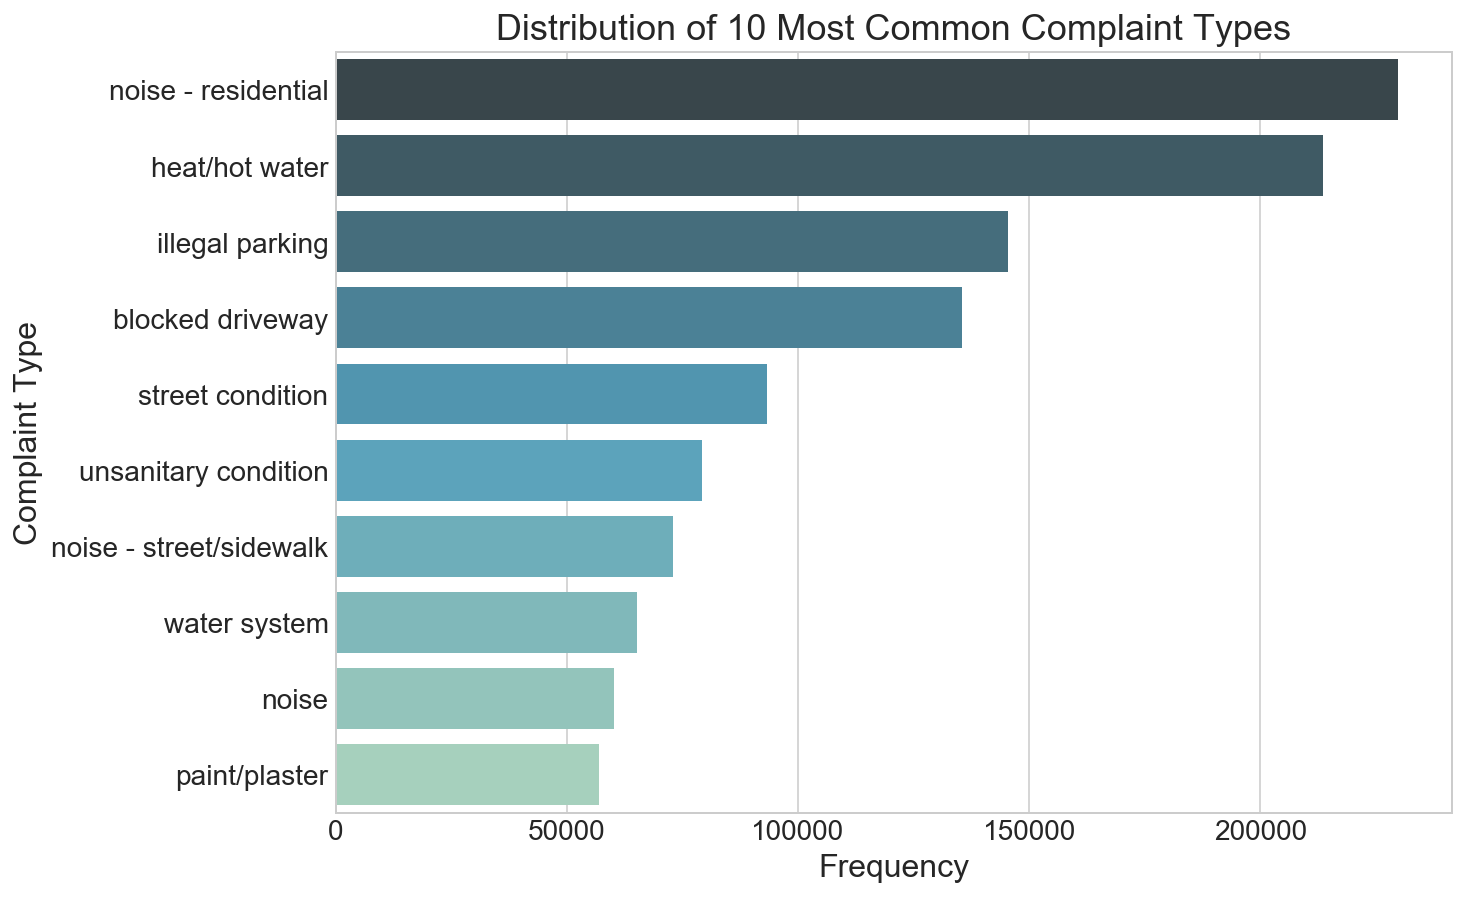

In [149]:
data = df[df['complaint_type'].isin(common_complaints)]

plt.figure(figsize = (10,7))

sns.countplot(y=data['complaint_type'],
              order=data['complaint_type'].value_counts().index,
              palette='GnBu_d')

plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Complaint Type', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Distribution of 10 Most Common Complaint Types', fontsize=18);

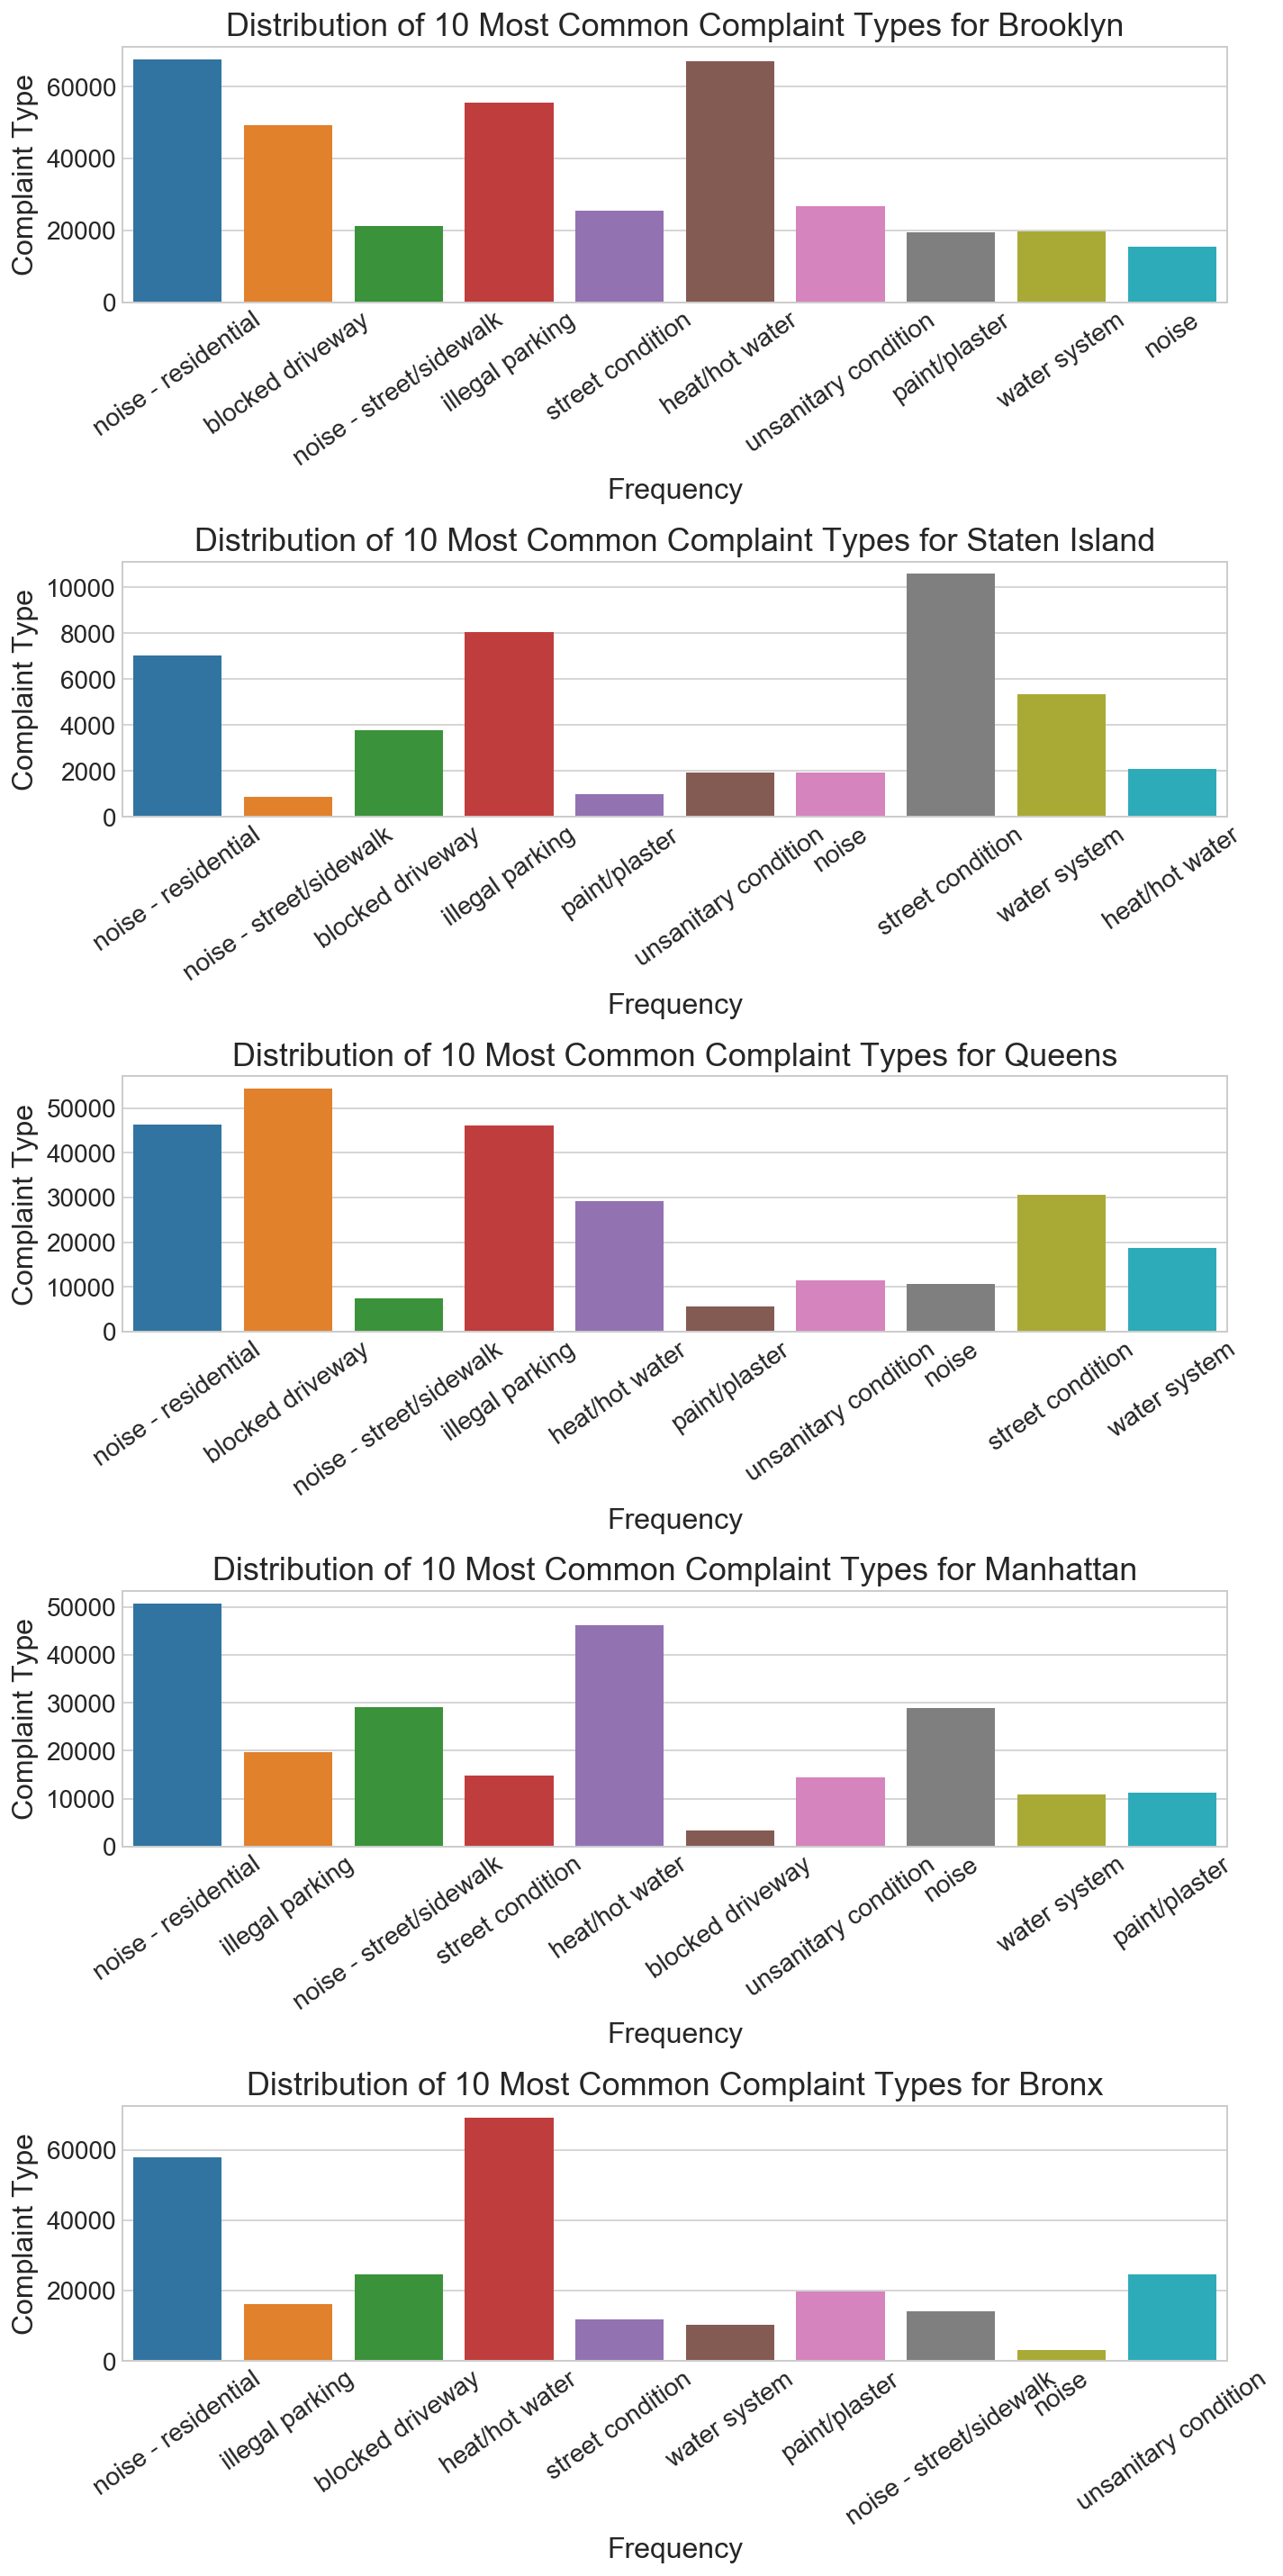

In [148]:
data=df[df['complaint_type'].isin(common_complaints)]

plt.figure(figsize = (10,20))

for i, borough in enumerate(df['borough'].unique(), start=1):
    plt.subplot(5, 1, i), sns.countplot(x=data[data['borough'] == borough]['complaint_type'])
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Complaint Type', fontsize=16)
    plt.xticks(fontsize=14, rotation=35)
    plt.yticks(fontsize=14)
    plt.title('Distribution of 10 Most Common Complaint Types for ' + str(borough.title()), fontsize=18)
    plt.tight_layout();

### Consider only the 10 most common overall complaint types.  For the 10 most populous zip codes, how many of each of those 10 types were there in 2017?
---

In [150]:
zips = df[['zip', 'population']].groupby(['zip', 'population']) \
                                .count() \
                                .sort_values(by='population', ascending=False) \
                                .head(10) \
                                .reset_index()
zips = pd.Series.tolist(zips['zip'])

In [151]:
zips

[11368, 11226, 11373, 11220, 11385, 10467, 10025, 11208, 11236, 11207]

In [152]:
common_complaints

Index(['noise - residential', 'heat/hot water', 'illegal parking',
       'blocked driveway', 'street condition', 'unsanitary condition',
       'noise - street/sidewalk', 'water system', 'noise', 'paint/plaster'],
      dtype='object', name='complaint_type')

In [153]:
borough_dict = {}
for zip_code in zips:
    print('{}: {}'.format(zip_code, df[df['zip'] == zip_code]['borough'].unique()))

11368: ['queens']
11226: ['brooklyn']
11373: ['queens']
11220: ['brooklyn']
11385: ['queens']
10467: ['bronx']
10025: ['manhattan']
11208: ['brooklyn']
11236: ['brooklyn']
11207: ['brooklyn']


In [154]:
data.head()

,complaint_type,zip,borough,location,population
5,noise - residential,11373,queens,"40.746695607794884,-73.87675329807432",100820.0
6,noise - residential,11203,brooklyn,"40.6551106404762,-73.92395505618256",76174.0
11,blocked driveway,11212,brooklyn,"40.662708741097745,-73.92478622811217",84500.0
12,noise - residential,10128,manhattan,"40.78073276608451,-73.94866490309134",60453.0
13,blocked driveway,11419,queens,"40.690678795114316,-73.83202042272806",47211.0


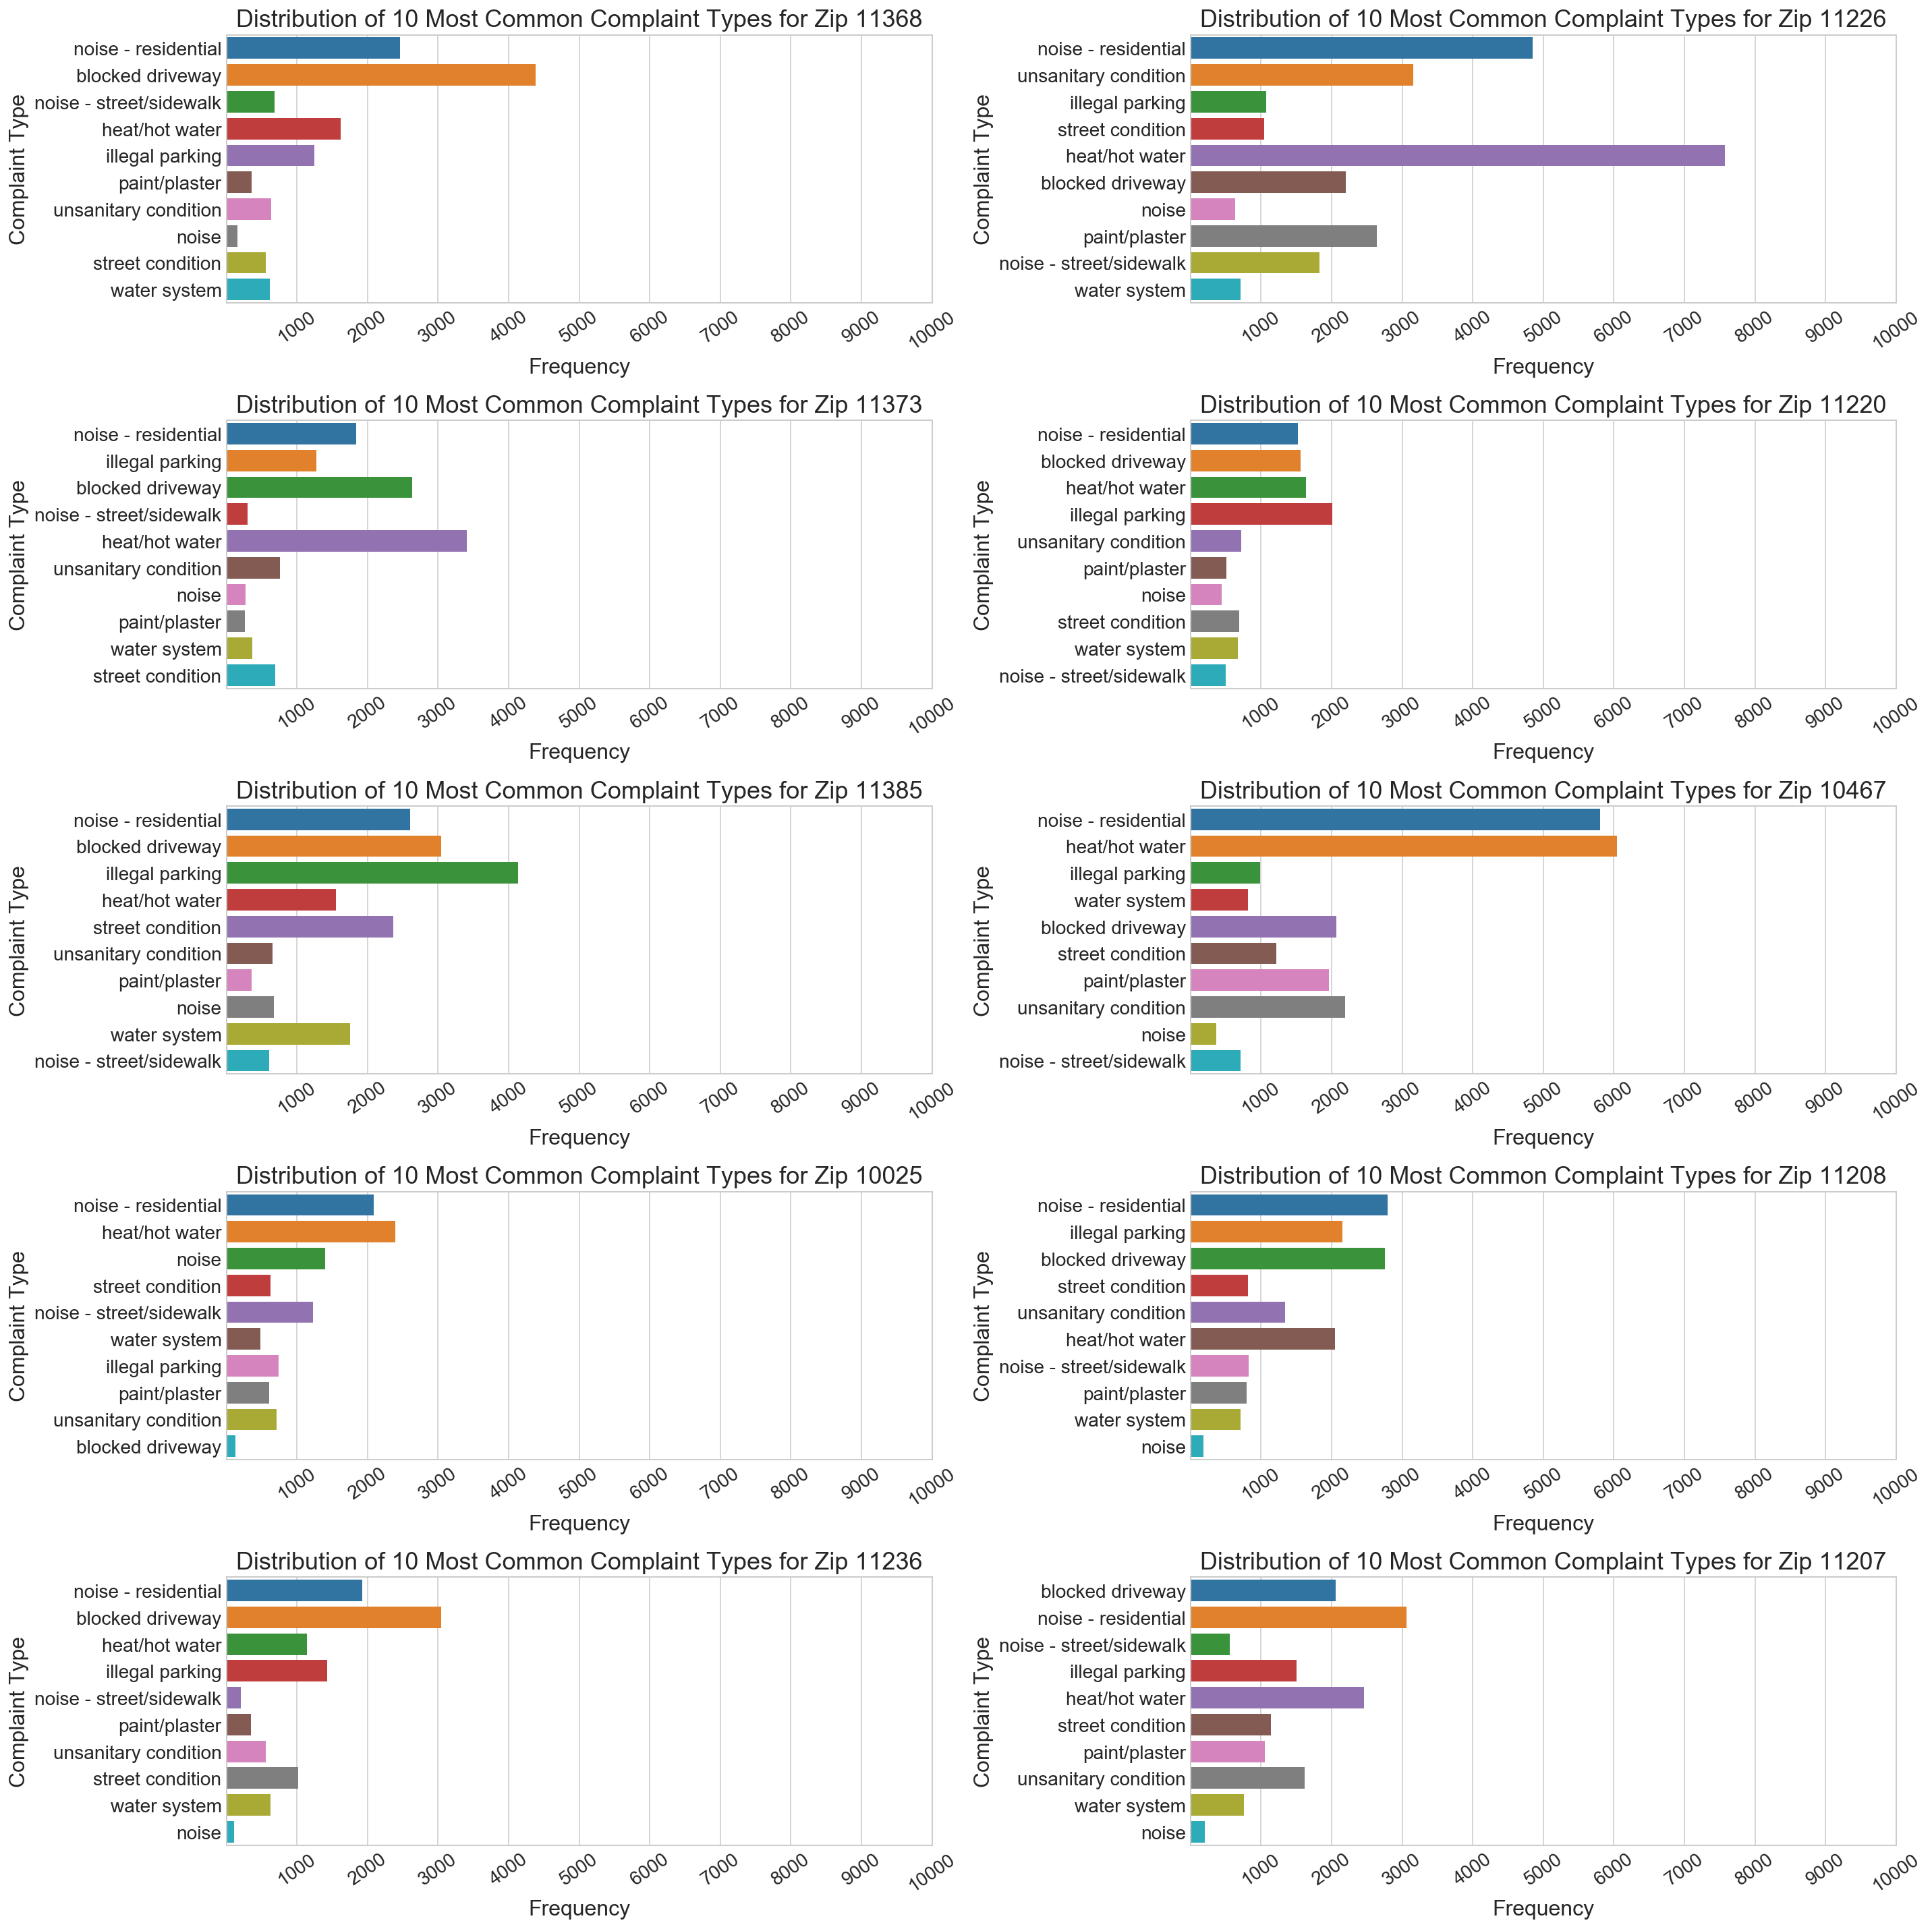

In [155]:
data = df[(df['complaint_type'].isin(common_complaints)) & (df['zip'].isin(zips))]

plt.figure(figsize = (20,20))

for i, zip_code in enumerate(zips, start=1):
    plt.subplot(5, 2, i), sns.countplot(y=data[data['zip'] == zip_code]['complaint_type'])
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Complaint Type', fontsize=16)
    plt.xticks(np.arange(1000, 11000, 1000), fontsize=14, rotation=35)
    plt.yticks(fontsize=14)
    plt.title('Distribution of 10 Most Common Complaint Types for Zip ' + str(zip_code), fontsize=18)
    plt.tight_layout();

###    Considering all complaint types. Which boroughs are the biggest "complainers" relative to the size of the population in 2017? Meaning, calculate a complaint-index that adjusts for population of the borough.
---

In [46]:
df.head()

,complaint_type,zip,borough,location,population
0,vacant lot,11238,brooklyn,"40.67654750057022,-73.96352995988079",49262.0
1,vacant lot,11211,brooklyn,"40.71758731876742,-73.95584537725969",90117.0
2,vacant lot,11211,brooklyn,"40.71186304379185,-73.9522204322487",90117.0
3,vacant lot,10305,staten island,"40.59279428994732,-74.0695035852305",41749.0
4,vacant lot,11208,brooklyn,"40.67974038452862,-73.86737691477967",94469.0


In [50]:
# pulled zip codes for each borough from https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm
brx_zips = [10453, 10457, 10460, 10458, 10467, 10468, 10451, 10452, 10456, 10454, 10455, 10459,
10474, 10463, 10471, 10466, 10469, 10470, 10475, 10461, 10462,10464, 10465, 10472, 10473]

bk_zips = [11212, 11213, 11216, 11233, 11238, 11209, 11214, 11228, 11204, 11218, 11219,
11230, 11234, 11236, 11239, 11223, 11224, 11229, 11235, 11201, 11205, 11215, 11217, 11231,
11203, 11210, 11225, 11226, 11207, 11208, 11211, 11222, 11220, 11232, 11206, 11221, 11237]

mhn_zips = [10026, 10027, 10030, 10037, 10039, 10001, 10011, 10018, 10019, 10020, 10036,
10029, 10035, 10010, 10016, 10017, 10022, 10012, 10013, 10014, 10004, 10005, 10006, 10007, 
10038, 10280, 10002, 10003, 10009, 10021, 10028, 10044, 10065, 10075, 10128, 10023, 10024, 
10025, 10031, 10032, 10033, 10034, 10040]

qns_zips = [11361, 11362, 11363, 11364, 11354, 11355, 11356, 11357, 11358, 11359, 11360,
11365, 11366, 11367, 11412, 11423, 11432, 11433, 11434, 11435, 11436, 11101, 11102, 11103,
11104, 11105, 11106, 11374, 11375, 11379, 11385, 11691, 11692, 11693, 11694, 11695, 11697,
11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428, 11429, 11414, 11415, 11416, 11417, 
11418, 11419, 11420, 11421, 11368, 11369, 11370, 11372, 11373, 11377, 11378]

sil_zips = [10302, 10303, 10310, 10306, 10307, 10308, 10309, 10312, 10301, 10304, 10305, 10314]

all_zips = brx_zips + bk_zips + mhn_zips + qns_zips + sil_zips

In [51]:
# one of the zip codes from above is missing in the census data
print(len(all_zips))
print(population[population['zip'].isin(all_zips)].shape[0])

178
177


In [52]:
# the zip code belongs to queens
pop_zips = pd.Series.tolist(population[population['zip'].isin(all_zips)]['zip'])
set(all_zips) - set(pop_zips)

{11695}

In [53]:
# there are only 25 entries belonging to this zip
# these can be ignored
df[df['zip'] == 11695].shape[0]

25

In [54]:
df_zips = df[df['zip'].isin(pop_zips)].copy()

In [55]:
# no unspecified boroughs in this data
df_zips['borough'].unique()

array(['brooklyn', 'staten island', 'queens', 'manhattan', 'bronx'],
      dtype=object)

In [56]:
df_zips.head()

,complaint_type,zip,borough,location,population
0,vacant lot,11238,brooklyn,"40.67654750057022,-73.96352995988079",49262.0
1,vacant lot,11211,brooklyn,"40.71758731876742,-73.95584537725969",90117.0
2,vacant lot,11211,brooklyn,"40.71186304379185,-73.9522204322487",90117.0
3,vacant lot,10305,staten island,"40.59279428994732,-74.0695035852305",41749.0
4,vacant lot,11208,brooklyn,"40.67974038452862,-73.86737691477967",94469.0


In [57]:
df_zips = df_zips[['borough', 'zip', 'population', 'complaint_type']]

In [58]:
df_zips_gby = df_zips.groupby(['zip', 'population', 'complaint_type']).count().reset_index()
df_zips_gby.rename(columns={'borough': 'complaint_count_by_zip'}, inplace=True)

In [79]:
# add borough to back into df_zips_gby  dataframe
df_zips_gby['borough'] = 0

df_zips_gby.loc[df_zips_gby['zip'].isin(brx_zips), 'borough'] = 'bronx'
df_zips_gby.loc[df_zips_gby['zip'].isin(bk_zips), 'borough'] = 'brooklyn'
df_zips_gby.loc[df_zips_gby['zip'].isin(mhn_zips), 'borough'] = 'manhattan'
df_zips_gby.loc[df_zips_gby['zip'].isin(qns_zips), 'borough'] = 'queens'
df_zips_gby.loc[df_zips_gby['zip'].isin(sil_zips), 'borough'] = 'staten island'

df_zips_gby = df_zips_gby[['borough', 'zip', 'population', 'complaint_type', 'complaint_count_by_zip']]

In [86]:
df_zips_gby[df_zips_gby['borough'] == 'bronx']['complaint_count_by_zip'].sum()

450987

In [80]:
df_zips_gby.head()

,borough,zip,population,complaint_type,complaint_count_by_zip
0,manhattan,10001,21102.0,advocate - other,1
1,manhattan,10001,21102.0,advocate - rpie,1
2,manhattan,10001,21102.0,air quality,59
3,manhattan,10001,21102.0,alzheimer's care,1
4,manhattan,10001,21102.0,animal abuse,33


In [103]:
d = pd.Series.to_dict(df_zips_gby.groupby(['borough']).sum()['complaint_count_by_zip'])
d

{'bronx': 450987,
 'brooklyn': 752480,
 'manhattan': 476204,
 'queens': 584257,
 'staten island': 129068}

In [100]:
df_zips_gby['total_complaint_count_by_borough'] = df_zips_gby['borough'].map(d)

/Users/sean/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [105]:
for borough in d.keys():
    print(borough, ': ', d[borough] / df_zips_gby[df_zips_gby['borough'] == borough]['population'].unique()[0])

bronx :  9.865618095508935
brooklyn :  14.717571585041464
manhattan :  22.56677092218747
queens :  41.68500285388128
staten island :  3.250591850098222
